In [21]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scripts.ising_simulation import IsingSimulation
from joblib import Parallel, delayed
from scipy import optimize
from scipy.stats import zscore
import pickle

In [6]:
bold = np.loadtxt('../data/50003_timeseries.txt')
bold_bin = np.zeros(bold.shape)
bold_bin[np.where(bold>=0)] = 1
bold_bin[np.where(bold<0)] = -1
n_rois = bold_bin.shape[1]
n_timesteps = bold_bin.shape[0]

In [7]:
sim_timesteps = 300
eq_steps = 1000     #  number of MC sweeps for equilibration
σ = 10000
α = 1

In [8]:

def loss(J, s, beta):
#     print(s.shape)
    J = np.reshape(J, (n_rois, n_rois))
#     print(J.shape)
    term1 = 0
    term2 = 0
    for t in range(n_timesteps):
        C = beta * J @ s[t].T
        term1 += C @ s[t].T
        term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))
    return -(term1+term2)/n_timesteps

def gradient(J, s, beta):
    J = np.reshape(J, (n_rois, n_rois))
    grad = np.zeros((n_rois, n_rois))
    for t in range(n_timesteps):
        C = beta * J @ s[t].T
        grad += np.outer(s[t], s[t].T) - np.outer(np.tanh(C).T, s[t])
    grad = grad * beta/n_timesteps
    return -grad.flatten()

def gradient_descent(max_iterations,w_init,
                     obj_func,grad_func,extra_param = (),
                     learning_rate=0.05,momentum=0.8, threshold=0.001, disp=False):
    
    w = w_init
    w_history = [w]
    f_history = [obj_func(w,*extra_param)]
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while i<max_iterations and diff > threshold:
        grad = grad_func(w,*extra_param)
        # print("from func", grad.shape)
        grad = np.reshape(grad, (n_rois, n_rois))
        # print(grad.shape)
        delta_w = -learning_rate*grad
        w = w+delta_w
        f_history.append(obj_func(w,*extra_param))
        w_history.append(w)
        if i%10 == 0 and disp: 
            print(f"iteration: {i} loss: {f_history[-1]} grad: {np.sum(grad)}")
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history

In [30]:
def corr_analysis(beta, fc, sim_timesteps=n_timesteps, n_folds=5, train=True, J_max=None):
    f_hist = []
    J_corr_hist = []
    corr_hist = []
    if train: 
        J = np.random.uniform(0, 1, size=(n_rois, n_rois))
        J = (J + J.T)/2 # making it symmetric
        np.fill_diagonal(J, 0)
        J_hist, f_hist = gradient_descent(σ, J, loss, gradient, extra_param=(bold_bin, beta) , learning_rate=α, threshold=0.001, disp=True)
        J_max = J_hist[f_hist.index(min(f_hist))]
        for i in J_hist: 
            sim = IsingSimulation(n_rois, beta, coupling_mat=True, J=i)
            _, sim_fc = sim.getTimeseries(sim_timesteps)
            J_corr_hist.append(
                np.corrcoef(np.triu(fc).flatten(), np.triu(i).flatten())[0, 1])
            corr_hist.append(
                np.corrcoef(np.triu(fc).flatten(), np.triu(sim_fc).flatten())[0, 1]
            )
        

        # J_max = optimize.fmin_cg(loss, x0=J.flatten(), fprime=gradient, args=(bold_bin, beta))
        # J_max = np.reshape(J_max, (n_rois, n_rois))

    sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J_max)
    for i in range(eq_steps):
        sim.step()
    corrs = np.zeros(n_folds)
    self_corr = np.zeros(n_folds)
    _, sample_fc = sim.getTimeseries(sim_timesteps)
    for i in range(n_folds):
        _, sim_fc = sim.getTimeseries(sim_timesteps)
        corrs[i] = np.corrcoef(np.triu(fc).flatten(), np.triu(sim_fc).flatten())[0, 1]
        self_corr[i] = np.corrcoef(np.triu(sample_fc).flatten(), np.triu(sim_fc).flatten())[0, 1]
    res = {
        'mean': np.mean(corrs),
        'std': np.std(corrs),
        'self_corr_mean': np.mean(self_corr),
        'self_corr_std': np.std(self_corr),
        'J_corr': np.corrcoef(np.triu(fc).flatten(), np.triu(J_max).flatten())[0, 1],
        'J_corr_hist': J_corr_hist,
        'f_hist': f_hist,
        'corr_hist': corr_hist,
    }
    if train:
        return res, J_max
    return res

## Effect of $\beta$


In [31]:
fc = 1/n_timesteps * bold_bin.T @ bold_bin
res, J = corr_analysis(0.1, fc)

iteration: 0 loss: 124.2568424247649 grad: 186.59666530918997
iteration: 10 loss: 69.17482436882315 grad: 133.50215749542767
iteration: 20 loss: 47.842349781009894 grad: 67.59465812891534
iteration: 30 loss: 38.46520188917041 grad: 33.426255230249126
iteration: 40 loss: 32.791700918688285 grad: 17.953742513325142
iteration: 50 loss: 28.788020579659168 grad: 10.392251164483122
iteration: 60 loss: 25.743048219783915 grad: 6.30316504984823
iteration: 70 loss: 23.321130711046585 grad: 3.8929051751687194
iteration: 80 loss: 21.335357005000034 grad: 2.374329534187428
iteration: 90 loss: 19.670693102837635 grad: 1.368031046961788
iteration: 100 loss: 18.25129761741586 grad: 0.6751526432233046
iteration: 110 loss: 17.024561659594244 grad: 0.1839118653849288
iteration: 120 loss: 15.952536407468145 grad: -0.17224365831878638
iteration: 130 loss: 15.00698624813485 grad: -0.434856609977428
iteration: 140 loss: 14.16636789416121 grad: -0.6308982910174185
iteration: 150 loss: 13.413899030149173 grad

In [ ]:
file = open('results/gd_0.1.pkl', 'wb')
pickle.dump(res, file)

<function matplotlib.pyplot.savefig(*args, **kwargs)>

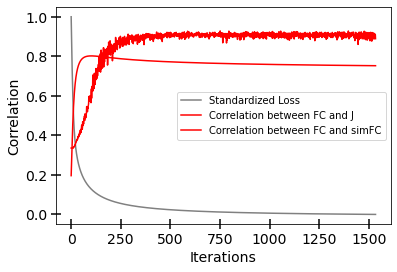

In [32]:
L = (res['f_hist'] - min(res['f_hist']))/(max(res['f_hist']) - min(res['f_hist']))
plt.plot(L, color='gray', label='Standardized Loss')
plt.plot(res['J_corr_hist'], color='red', label='Correlation between FC and J')
plt.plot(res['corr_hist'], color='red', label='Correlation between FC and simFC')
plt.xlabel(r'Iterations', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.legend()
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')
plt.savefig

In [137]:
fc = 1/n_timesteps * bold_bin.T @ bold_bin
results = Parallel(n_jobs=8)(delayed(corr_analysis)(i, fc) for i in np.linspace(0, 4, 20))

Optimization terminated successfully.
         Current function value: 80.405073
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000243
         Iterations: 24
         Function evaluations: 96
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: 0.000105
         Iterations: 28
         Function evaluations: 110
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.000118
         Iterations: 28
         Function evaluations: 116
         Gradient evaluations: 116
Optimization terminated successfully.
         Current function value: 0.000156
         Iterations: 30
         Function evaluations: 127
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: 0.000469
         Iterations: 29
         Function evaluations: 1

In [149]:
means = []
std = []
self_mean = []
self_std = []
J_corr = []
betas = np.linspace(0, 4, 20)
for i in results:
    means.append(i[0]['mean'])
    std.append(i[0]['std'])
    self_mean.append(i[0]['self_corr_mean'])
    self_std.append(i[0]['self_corr_std'])
    J_corr.append(i[0]['J_corr'])

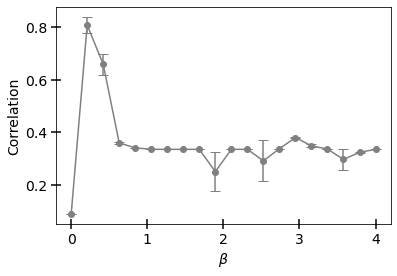

In [148]:
plt.errorbar(betas, means, fmt='o-', yerr=std, capsize=5, color='gray')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

In [ ]:

plt.errorbar(betas, self_mean, fmt='o-', yerr=self_std, capsize=5, color='gray')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title('Consistency in simulated FC')
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

In [ ]:
plt.errorbar(betas, J_corr, fmt='o-', capsize=5, color='gray')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title('Relationship between J and FC')
plt.tick_params(axis='both', which='major', direction='inout', length = 10, width = 1.5, labelsize='14')

## Ideal simulation time for correlation with functional connectivity

In [117]:
_, J_max = corr_analysis(0.1, fc, n_folds=0)

Optimization terminated successfully.
         Current function value: 0.001872
         Iterations: 24
         Function evaluations: 148
         Gradient evaluations: 148


/home/shivansh/miniconda3/envs/brain/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shivansh/miniconda3/envs/brain/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/shivansh/miniconda3/envs/brain/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/shivansh/miniconda3/envs/brain/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/shivansh/miniconda3/envs/brain/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [124]:
res = Parallel(n_jobs=8)(delayed(corr_analysis)(0.1, fc, sim_timesteps=sim_timesteps, train=False, J_max=J_max) for sim_timesteps in range(50, 500, 50))
    

In [129]:
mean_corr = [i['mean'] for i in res]

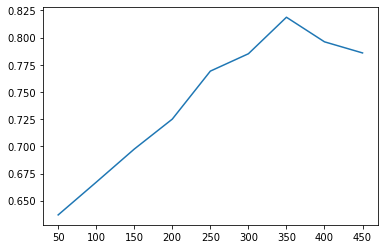

In [131]:
plt.plot(range(50, 500, 50), mean_corr)